In [1]:
import geopandas as gpd
from shapely.geometry import LineString, Point
import geemap
import numpy as np
import ee
import os
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
ee.Initialize()

In [8]:

# Step 1: Load local shapefile
shapefile_path = r"D:\Okavango\Data\Cross_Sections\new\Okavango_cross_sections_UTM.shp"
gdf = gpd.read_file(shapefile_path)

# Step 2: Generate points every N meters along each line with reversed distance
def sample_points_along_line_with_reversed_distances(geom, spacing=30):
    """
    Returns list of (point_geom, reversed_distance_m)
    """
    if geom.length == 0:
        return []
    total_len = geom.length
    distances = list(range(0, int(total_len) + 1, spacing))
    return [(geom.interpolate(d), total_len - d) for d in distances]

# Step 3: Create new GeoDataFrame of points
point_rows = []
for idx, row in gdf.iterrows():
    xs_id = row['id']  # ID field
    line = row.geometry
    sampled = sample_points_along_line_with_reversed_distances(line)
    for pt, reversed_dist in sampled:
        point_rows.append({'geometry': pt, 'xs_id': xs_id, 'dist_m': reversed_dist})

points_gdf = gpd.GeoDataFrame(point_rows, crs=gdf.crs)

# Step 4: Convert to EE FeatureCollection
fc_points = geemap.gdf_to_ee(points_gdf, geodesic=False)

# Step 5: Display on map
Map = geemap.Map()
Map.centerObject(fc_points, zoom=12)
Map.addLayer(fc_points, {"color": "red"}, "Cross-Section Points (Reversed)")
Map.addLayerControl()
Map

Map(center=[-19.334029789484326, 22.82872695442532], controls=(WidgetControl(options=['position', 'transparent…

In [9]:
def plot_dswe_cross_section(points_fc, xs_id, year, month, dswe_asset_folder):

    # Format asset name
    month_str = f"{month:02d}"
    asset_name = f"DSWE_{year}_{month_str}"
    asset_path = f"{dswe_asset_folder}/{asset_name}"

    # Load DSWE image
    dswe_img = ee.Image(asset_path)

    # Filter points for the selected cross-section
    section_points = points_fc.filter(ee.Filter.eq('xs_id', xs_id))

    # Sample DSWE image at those points
    sampled = dswe_img.sampleRegions(
        collection=section_points,
        scale=30,
        geometries=True
    ).getInfo()

    # Extract accurate distances and DSWE values
    distances = []
    dswe_values = []
    for f in sampled['features']:
        dist = f['properties'].get('dist_m')
        val = f['properties'].get('dswe')
        if dist is not None and val is not None:
            distances.append(dist)
            dswe_values.append(val)

    # Sort by distance to ensure proper x-axis order
    sorted_pairs = sorted(zip(distances, dswe_values), key=lambda x: x[0])
    distances_sorted, dswe_sorted = zip(*sorted_pairs) if sorted_pairs else ([], [])

    # Plot
    plt.figure(figsize=(10, 4))
    plt.scatter(distances_sorted, dswe_sorted, c='blue', s=10)
    plt.yticks([0, 1, 2, 3, 4])
    plt.ylim(-0.5, 4.5)
    plt.xlabel('Distance along cross-section (m)')
    plt.ylabel('DSWE Value')
    plt.title(f'DSWE across Section {xs_id} for {year}-{month_str}')
    plt.grid(True)
    plt.show()


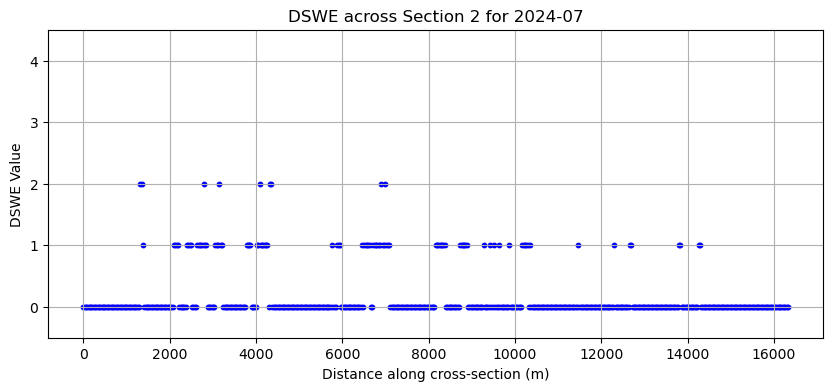

In [10]:
plot_dswe_cross_section(
    points_fc=fc_points,
    xs_id=2,
    year=2024,
    month=7,
    dswe_asset_folder='projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m'
)

In [11]:
def export_dswe_cross_section_csv(points_fc, xs_id, start_year, start_month, end_year, end_month, dswe_asset_folder, output_csv_path):
    # Build date list
    start = dt.datetime(start_year, start_month, 1)
    end = dt.datetime(end_year, end_month, 1)
    dates = []
    current = start
    while current <= end:
        dates.append((current.year, current.month))
        current += relativedelta(months=1)

    # Filter points by cross-section ID
    section_points = points_fc.filter(ee.Filter.eq('xs_id', xs_id))

    # Initialize storage
    all_data = {}

    for year, month in dates:
        month_str = f"{month:02d}"
        date_str = f"{year}_{month_str}"
        asset_path = f"{dswe_asset_folder}/DSWE_{date_str}"

        try:
            dswe_img = ee.Image(asset_path)
            sampled = dswe_img.sampleRegions(
                collection=section_points,
                scale=30,
                geometries=True
            ).getInfo()
        except Exception as e:
            print(f"Skipping {date_str}: {e}")
            continue

        for f in sampled['features']:
            dist = f['properties'].get('dist_m')
            val = f['properties'].get('b1')
            if dist is not None:
                dist = float(dist)
                if dist not in all_data:
                    all_data[dist] = {}
                all_data[dist][date_str] = val

    # Create DataFrame
    df = pd.DataFrame.from_dict(all_data, orient='index')
    df.index.name = 'dist_m'
    df = df.sort_index()
    df = df.sort_index(axis=1)  # Sort columns (dates) if needed

    # Export
    df.to_csv(output_csv_path)
    print(f"Exported DSWE time-series cross-section to: {output_csv_path}")


In [12]:
export_dswe_cross_section_csv(
    points_fc=fc_points,
    xs_id=2,
    start_year=1984,
    start_month=6,
    end_year=2025,
    end_month=3,
    dswe_asset_folder='projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m',
    output_csv_path= r'D:\Okavango\Data\SpatioTemporal_Inundation\dswe_Kajaja_profile.csv'
)


Skipping 1984_08: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m/DSWE_1984_08' not found (does not exist or caller does not have access).
Skipping 1984_12: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m/DSWE_1984_12' not found (does not exist or caller does not have access).
Skipping 1985_01: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m/DSWE_1985_01' not found (does not exist or caller does not have access).
Skipping 1985_02: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m/DSWE_1985_02' not found (does not exist or caller does not have access).
Skipping 1985_03: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m/DSWE_1985_03' not found (does not exist or caller does not have access).
Skipping 1985_05: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE

KeyboardInterrupt: 

In [36]:
def plot_water_surface_confidence(file_path):
    # Load CSV and set dist_m as index
    df = pd.read_csv(file_path)
    df = df.set_index('dist_m')

    # Transpose to get time on Y-axis
    data_matrix = df.T
    data_matrix.index = pd.to_datetime(data_matrix.index, format='%Y_%m')

    # Drop rows (months) that are completely NaN
    data_matrix = data_matrix.dropna(how='all')

    # Define custom color palette
    colors = ['#D2B48C', '#BFDFFF', '#7FBFFF', '#3F8FFF', '#004F8F']
    cmap = ListedColormap(colors)

    # Plot
    plt.figure(figsize=(12, 8))
    plt.imshow(data_matrix, aspect='auto', cmap=cmap, origin='lower', vmin=0, vmax=4)

    # Colorbar with DSWE class labels
    cbar = plt.colorbar(ticks=[0, 1, 2, 3, 4])
    cbar.ax.set_yticklabels([
        'No Water (0)',
        'Low-confidence water (1)',
        'Potential wetland (2)',
        'Moderate-confidence water (3)',
        'High-confidence water (4)'
    ])

    plt.xlabel('Distance Along Cross-Section (m)')
    plt.ylabel('Year')

    # Y-axis ticks (every 5 years)
    years = pd.Series(data_matrix.index).dt.year
    label_years = [year for year in sorted(set(years)) if year % 5 == 0]
    label_dates = [data_matrix.index[years[years == year].index[0]] for year in label_years if year in years.values]
    y_ticks = [data_matrix.index.get_loc(date) for date in label_dates]
    plt.yticks(y_ticks, [str(date.year) for date in label_dates])

    # X-axis ticks (distance)
    x_ticks = np.linspace(0, len(data_matrix.columns) - 1, 10, dtype=int)
    plt.xticks(x_ticks, [f"{data_matrix.columns[i]:.0f}" for i in x_ticks], rotation=45)

    plt.title('Water Surface Coverage Confidence Over Time')
    plt.tight_layout()
    plt.show()



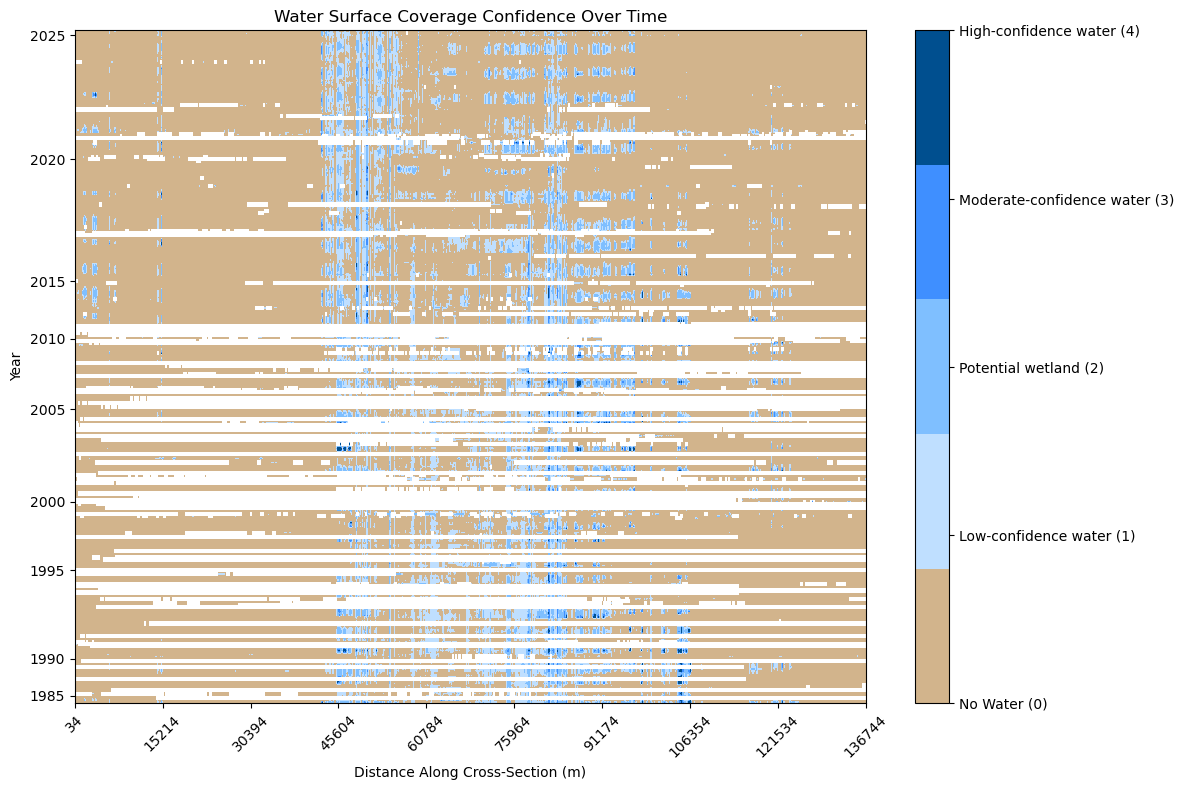

In [38]:
csv_path = "D:\Okavango\Data\SpatioTemporal_Inundation\dswe_Kwetsani_profile.csv"
plot_water_surface_confidence(csv_path)